In [1]:
import moviepy.editor as mpe
from glob import glob

In [2]:
import sys, os
import numpy as np
import scipy
from scipy import misc
#%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
video = mpe.VideoFileClip("download.mp4")

In [4]:
video.subclip(0,7).ipython_display(width=300)

 98%|█████████▊| 49/50 [00:00<00:00, 564.49it/s]


In [5]:
video.duration

50.0

In [6]:
(b,l)=video.size

In [7]:
def create_data_matrix_from_video(clip, k, scale):
    return np.vstack([scipy.misc.imresize(grayscale(clip.get_frame(i/float(k))).astype(int), scale).flatten() for i in range(k * int(clip.duration))]).T

In [8]:
def grayscale(x):
    return np.dot(x[...,:3], [0.299, 0.587, 0.114])

In [9]:
scale = 25   # to change resolution of image

dims = (int(l * (scale/100)), int(b * (scale/100)))

In [10]:
!pip3 install --user scipy==1.2.0

In [11]:

M = create_data_matrix_from_video(video, 100, scale)


In [12]:
print(dims, M.shape)

(60, 80) (4800, 5000)


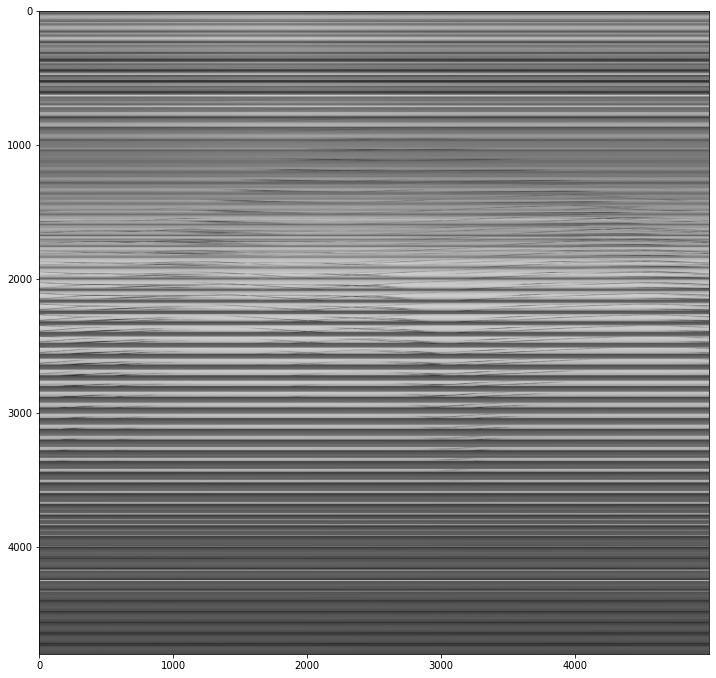

In [13]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

In [14]:
from sklearn import decomposition
u, s, v = decomposition.randomized_svd(M, 2)
u.shape, s.shape, v.shape


((4800, 2), (2,), (2, 5000))

In [15]:
low_rank = u @ np.diag(s) @ v
low_rank.shape



(4800, 5000)

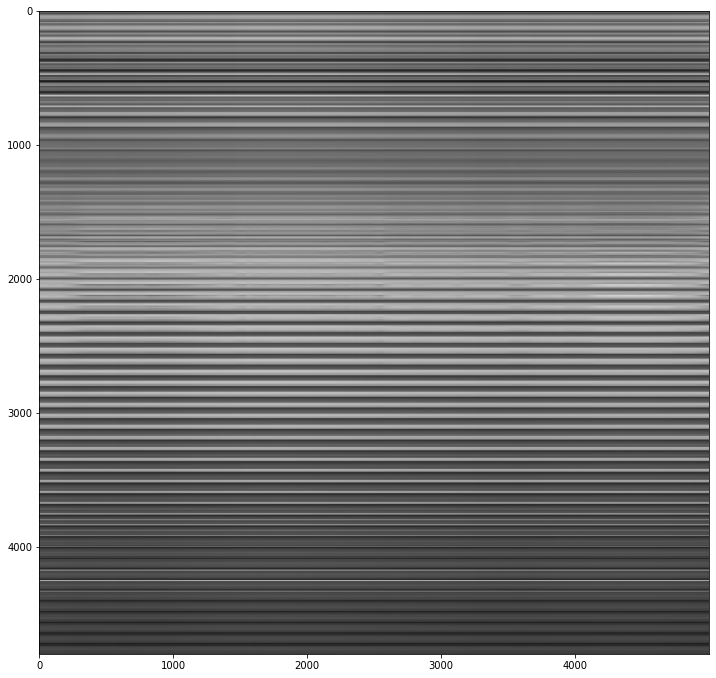

In [16]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

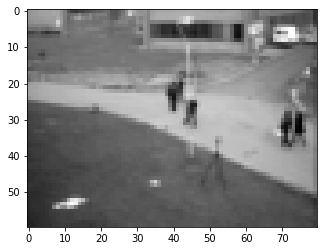

In [17]:
#original
plt.imshow(np.reshape(M[:,340], dims), cmap='gray');

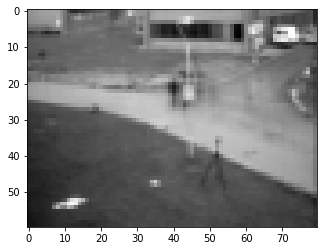

In [18]:
plt.imshow(np.reshape(low_rank[:,340], dims), cmap='gray');

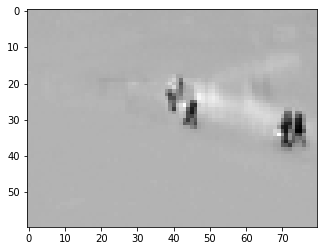

In [19]:
plt.imshow(np.reshape(M[:,340] - low_rank[:,340], dims), cmap='gray');

In [20]:
u, s, v = decomposition.randomized_svd(M, 1)
u.shape, s.shape, v.shape


((4800, 1), (1,), (1, 5000))

In [21]:
low_rank = u @ np.diag(s) @ v
low_rank.shape


(4800, 5000)

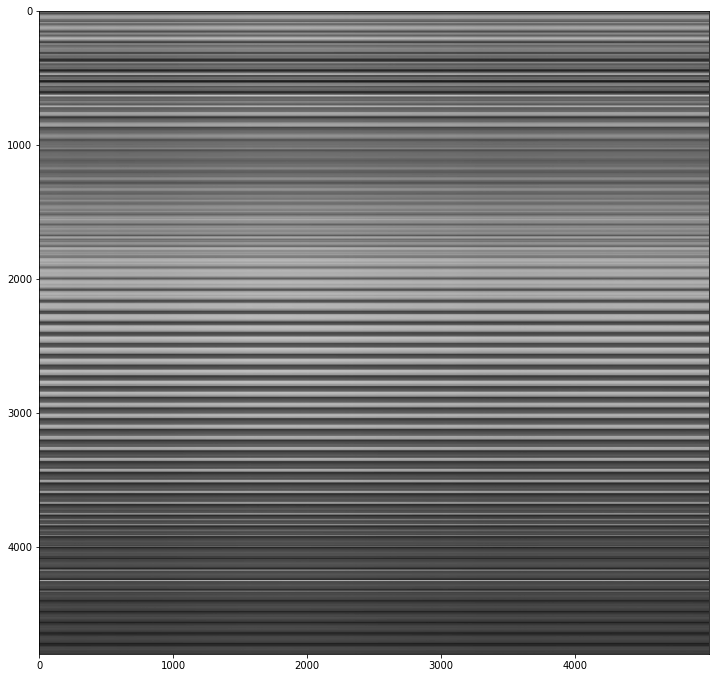

In [22]:

plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

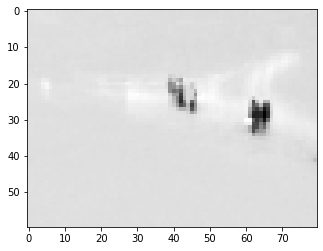

In [23]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');

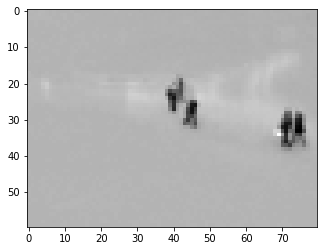

In [24]:
plt.imshow(np.reshape(M[:,340] - low_rank[:,340], dims), cmap='gray');

In [25]:
!pip3 install fbpca

  Created wheel for fbpca: filename=fbpca-1.0-cp37-none-any.whl size=11376 sha256=279b7f4c87c730bb1a99be99992cfdd922fae9e22c1ad9b1d91698f1d97cdaca
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
Successfully built fbpca


In [26]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

T=1e-9

def converged(Z, F_norm):
    err = np.linalg.norm(Z, 'fro') / F_norm
    print('Error: ', err)
    return err < T

 #Shrinkage operator for M = sign(M) max(|M| − τ, 0)
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

#truncated SVD
def T_svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)


def sigma1(M): return T_svd(M, 1)[1][0]
#return the largest singular value

#singular value threshold operator
def svd_reconstruct(M, rank, min_sv):
    u, s, v = T_svd(M, rank)
    s -= min_sv
    n = (s > 0).sum()
    # number of singular values > 1/mu is returned as n
    return u[:,:n] @ np.diag(s[:n]) @ v[:n], n


def pcp(X, maxiter=10, k=10): 
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape

    # BEST CHOICE FOR λ = 1/sqrt (max(m, n) ) since m >> n:
    lamda = 1/np.sqrt(m)
    sig1 = sigma1(X)
    Y = np.copy(X) / max(sig1, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/sig1;
    mu_bar = mu * 1e7; rho = k * 1.5
    
    F_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank :", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by shrinking original - low-rank matrix
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, we already have enough singular values. If not, add 5% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[340,:], L[340,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, F_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

In [27]:
#5 % of the original rank
m, n = M.shape
round(m * .05)

240

In [28]:
L, S, examples =  pcp(M, maxiter=5, k=10)

rank : 1
Error:  0.1271329937705616
rank : 241
Error:  0.038543378080243926
rank : 41
Error:  0.0048720822005306075
rank : 281
Error:  0.0004059391454736129
rank : 274
Error:  2.10255423765928e-05


In [29]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")


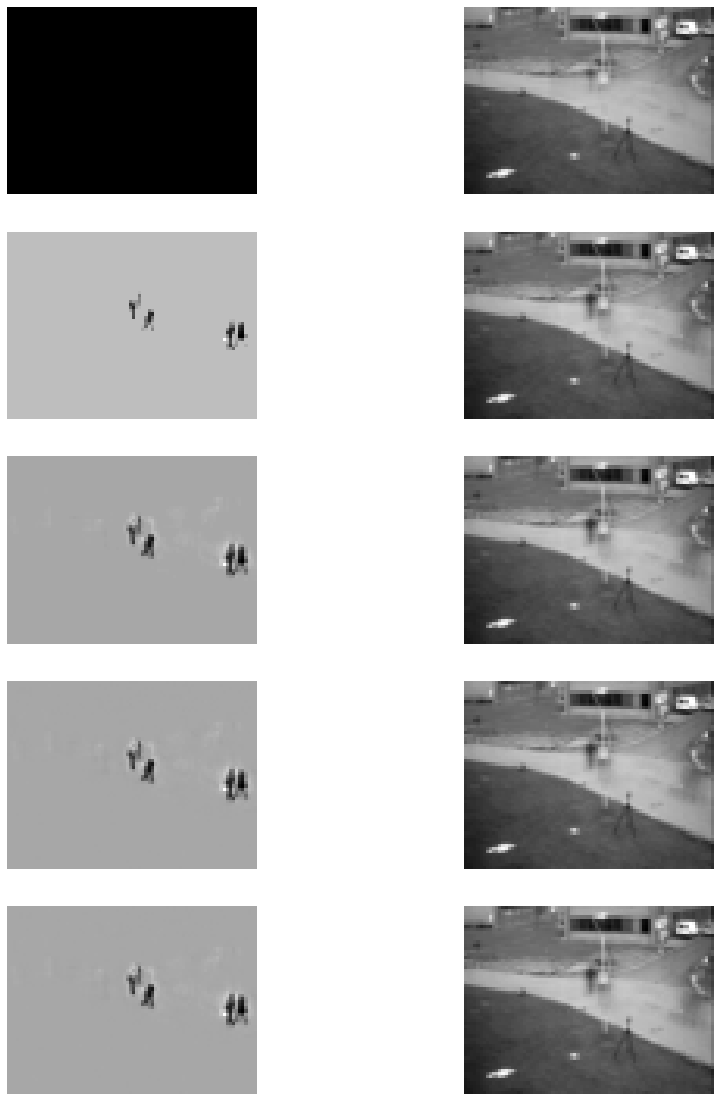

In [30]:
plots(examples, dims, rows=5)

In [32]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

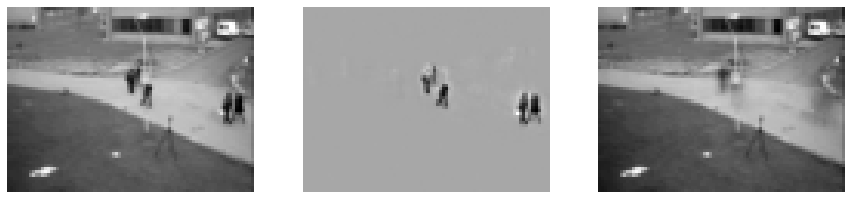

In [33]:
f = plt_images(M, S, L, [340], dims)

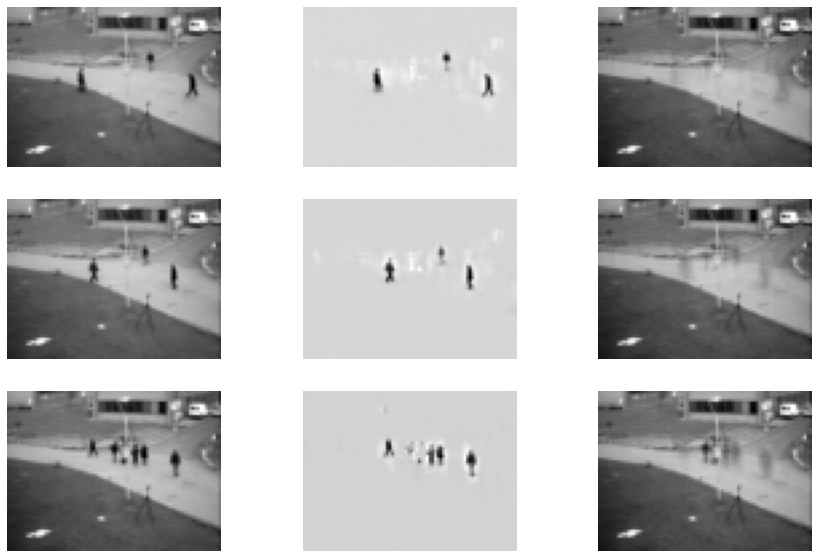

In [34]:
#to see a couple of sample outputs - the original, foregrounda n background
f = plt_images(M, S, L, [0, 100, 1000], dims)